C:\Users\sasit\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\sasit\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Random Forest model loaded from ./best_paddy_rf_model.pkl
Loading test images...
Processing class: Sheath Rot (Index: 0)
Processing class: Sheath Blight (Index: 1)
Processing class: BLB (Index: 2)
Processing class: FalseMut (Index: 3)
Processing class: Rice Blast (Index: 4)
Test data loaded: 78 images

Random Forest Accuracy: 78.21%

Classification Report:
               precision    recall  f1-score   support

   Sheath Rot       0.77      0.91      0.83        11
Sheath Blight       1.00      0.73      0.84        11
          BLB       0.88      0.61      0.72        23
     FalseMut       0.84      0.95      0.89        22
   Rice Blast       1.00      0.73      0.84        11
      Panicle       0.00      0.00      0.00         0
         Stem       0.00      0.00      0.00         0
         Leaf       0.00      0.00      0.00         0

     accuracy                           0.78        78
    macro avg       0.56      0.49      0.52        78
 weighted avg       0.89      0.78

C:\Users\sasit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sasit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sasit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


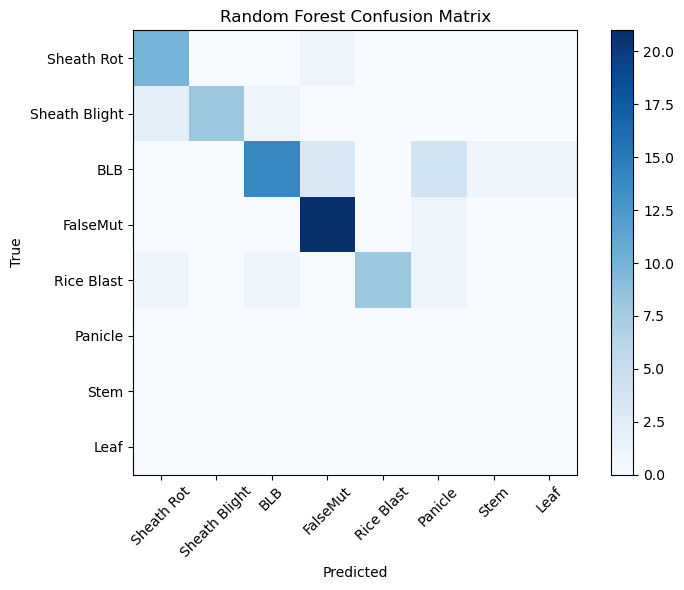

Error: Model file not found - ./best_paddy_svm_model.pkl
Decision Tree model loaded from ./best_paddy_dt_model.pkl
Loading test images...
Processing class: Sheath Rot (Index: 0)


C:\Users\sasit\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing class: Sheath Blight (Index: 1)
Processing class: BLB (Index: 2)
Processing class: FalseMut (Index: 3)
Processing class: Rice Blast (Index: 4)
Test data loaded: 78 images

Decision Tree Accuracy: 14.10%

Classification Report:


ValueError: Number of classes, 5, does not match size of target_names, 8. Try specifying the labels parameter

In [1]:
import os
import cv2
import numpy as np
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import graycomatrix, graycoprops, hog
import matplotlib.pyplot as plt

# Define constants from the notebook
IMG_SIZE = (256, 256)
classes = ["Sheath Rot ", "Sheath Blight ", "BLB ", "FalseMut ", "Rice Blast ", "Panicle", "Stem", "Leaf"]

# Feature extraction function (copied from the notebook)
def extract_image_features(image_path, IMG_SIZE=(256, 256), label=None):
    """
    Extract comprehensive image features combining texture, color, shape, histogram, and HOG features.

    Parameters:
    image_path (str): Path to the image file
    IMG_SIZE (tuple): Size to resize the image to (default: (256, 256))
    label: Optional label for the image

    Returns:
    np.array: Array of extracted features
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image not found - {image_path}")
        return None

    # Resize for consistency
    resized_image = cv2.resize(image, IMG_SIZE)

    # Convert BGR to RGB
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Apply Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    # Texture Features (GLCM)
    glcm = graycomatrix(blurred_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # Color Features (HSV)
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
    h_mean, s_mean, v_mean = np.mean(hsv_image, axis=(0, 1))
    h_std, s_std, v_std = np.std(hsv_image, axis=(0, 1))

    # Shape Features
    edges = cv2.Canny(blurred_image, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)
    avg_contour_area = np.mean([cv2.contourArea(c) for c in contours]) if contours else 0
    avg_contour_perimeter = np.mean([cv2.arcLength(c, True) for c in contours]) if contours else 0

    # Elongation Ratio
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        elongation_ratio = h / w if w != 0 else 0
        major_axis_length = max(w, h)
    else:
        elongation_ratio = 0
        major_axis_length = 0

    # Histogram Features (Color Distribution)
    hist_r = cv2.calcHist([rgb_image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([rgb_image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([rgb_image], [2], None, [256], [0, 256])

    # Normalize histogram features
    hist_r = cv2.normalize(hist_r, hist_r).flatten()
    hist_g = cv2.normalize(hist_g, hist_g).flatten()
    hist_b = cv2.normalize(hist_b, hist_b).flatten()

    # Combine histogram features
    hist_features = np.concatenate((hist_r, hist_g, hist_b))

    # HOG Feature Extraction
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

    # Basic features
    basic_features = np.array([
        contrast, correlation, energy, homogeneity,
        h_mean, s_mean, v_mean,
        h_std, s_std, v_std,
        num_contours, avg_contour_area, avg_contour_perimeter,
        elongation_ratio, major_axis_length
    ])

    # Combine all features
    combined_features = np.concatenate((basic_features, hist_features, hog_features))

    # Add label if provided
    if label is not None:
        combined_features = np.append(combined_features, label)

    return combined_features

# Function to load test data from folders
def load_test_data(test_path, classes):
    X_test = []
    y_test = []
    print("Loading test images...")
    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(test_path, class_name.strip())  # Strip extra spaces
        if not os.path.isdir(class_dir):
            print(f"Warning: Directory not found - {class_dir}")
            continue
        print(f"Processing class: {class_name.strip()} (Index: {idx})")
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
                img_path = os.path.join(class_dir, filename)
                features = extract_image_features(img_path)
                if features is not None:
                    X_test.append(features)
                    y_test.append(idx)
    return np.array(X_test), np.array(y_test)

# Main evaluation function
def evaluate_model(model_path, test_path, classes, model_name="Model"):
    # Check if model file exists
    if not os.path.isfile(model_path):
        print(f"Error: Model file not found - {model_path}")
        return

    # Load the saved model
    model = joblib.load(model_path)
    print(f"{model_name} model loaded from {model_path}")

    # Load test data
    X_test, y_test = load_test_data(test_path, classes)

    if len(X_test) == 0:
        print("No test images found. Evaluation aborted.")
        return

    print(f"Test data loaded: {X_test.shape[0]} images")

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=[c.strip() for c in classes]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Visualize Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.title(f"{model_name} Confusion Matrix")
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks(range(len(classes)), [c.strip() for c in classes], rotation=45)
    plt.yticks(range(len(classes)), [c.strip() for c in classes])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Usage example for local run
if __name__ == "__main__":
    # Paths for local execution (update as needed)
    test_path = os.path.join("./", "")  # Test images in traingdata/test
    rf_model_path = os.path.join("./", "best_paddy_rf_model.pkl")
    svm_model_path = os.path.join("./", "best_paddy_svm_model.pkl")
    dt_model_path = os.path.join("./", "best_paddy_dt_model.pkl")

    # Evaluate Random Forest
    evaluate_model(rf_model_path, test_path, classes, model_name="Random Forest")

    # Evaluate SVM
    evaluate_model(svm_model_path, test_path, classes, model_name="SVM")

    # Evaluate Decision Tree
    evaluate_model(dt_model_path, test_path, classes, model_name="Decision Tree")

In [17]:
import os
import cv2
import numpy as np
import joblib
from skimage.feature import graycomatrix, graycoprops, hog

# Define constants from the notebook
IMG_SIZE = (256, 256)
classes = ["Sheath Rot", "Sheath Blight", "BLB", "False bilg", "Rice Blast", "Panicle", "Stem", "Leaf"]

# Feature extraction function (copied from the notebook)
def extract_image_features(image_path, IMG_SIZE=(256, 256)):
    """
    Extract comprehensive image features combining texture, color, shape, histogram, and HOG features.

    Parameters:
    image_path (str): Path to the image file
    IMG_SIZE (tuple): Size to resize the image to (default: (256, 256))

    Returns:
    np.array: Array of extracted features
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image not found - {image_path}")
        return None

    # Resize for consistency
    resized_image = cv2.resize(image, IMG_SIZE)

    # Convert BGR to RGB
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Apply Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    # Texture Features (GLCM)
    glcm = graycomatrix(blurred_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # Color Features (HSV)
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
    h_mean, s_mean, v_mean = np.mean(hsv_image, axis=(0, 1))
    h_std, s_std, v_std = np.std(hsv_image, axis=(0, 1))

    # Shape Features
    edges = cv2.Canny(blurred_image, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)
    avg_contour_area = np.mean([cv2.contourArea(c) for c in contours]) if contours else 0
    avg_contour_perimeter = np.mean([cv2.arcLength(c, True) for c in contours]) if contours else 0

    # Elongation Ratio
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        elongation_ratio = h / w if w != 0 else 0
        major_axis_length = max(w, h)
    else:
        elongation_ratio = 0
        major_axis_length = 0

    # Histogram Features (Color Distribution)
    hist_r = cv2.calcHist([rgb_image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([rgb_image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([rgb_image], [2], None, [256], [0, 256])

    # Normalize histogram features
    hist_r = cv2.normalize(hist_r, hist_r).flatten()
    hist_g = cv2.normalize(hist_g, hist_g).flatten()
    hist_b = cv2.normalize(hist_b, hist_b).flatten()

    # Combine histogram features
    hist_features = np.concatenate((hist_r, hist_g, hist_b))

    # HOG Feature Extraction
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

    # Basic features
    basic_features = np.array([
        contrast, correlation, energy, homogeneity,
        h_mean, s_mean, v_mean,
        h_std, s_std, v_std,
        num_contours, avg_contour_area, avg_contour_perimeter,
        elongation_ratio, major_axis_length
    ])

    # Combine all features
    combined_features = np.concatenate((basic_features, hist_features, hog_features))

    return combined_features

# Function to predict class for a single image
def predict_image(image_path, model_path, classes, model_name="Model"):
    # Check if image and model files exist
    if not os.path.isfile(image_path):
        print(f"Error: Image file not found - {image_path}")
        return
    if not os.path.isfile(model_path):
        print(f"Error: Model file not found - {model_path}")
        return

    # Load the model
    model = joblib.load(model_path)
    print(f"{model_name} model loaded from {model_path}")

    # Extract features from the image
    features = extract_image_features(image_path, IMG_SIZE)
    if features is None:
        return

    # Reshape features for prediction (model expects 2D array: [1, n_features])
    features = features.reshape(1, -1)

    # Predict the class
    prediction = model.predict(features)[0]
    predicted_class = classes[prediction].strip()

    print(f"{model_name} Prediction for {os.path.basename(image_path)}: {predicted_class}")

# Usage example for local run
if __name__ == "__main__":
    # Paths for local execution (update as needed)
    image_path = "./Rice Blast/5390550.jpg"  # Replace with your image path
    rf_model_path = os.path.join("./", "best_paddy_rf_model.pkl")
    # svm_model_path = os.path.join("./", "best_paddy_svm_model.pkl")
    dt_model_path = os.path.join("./", "best_paddy_dt_model.pkl")

    # Predict with Random Forest
    predict_image(image_path, rf_model_path, classes, model_name="Random Forest")

    # Predict with SVM
    # predict_image(image_path, svm_model_path, classes, model_name="SVM")

    # Predict with Decision Tree
    predict_image(image_path, dt_model_path, classes, model_name="Decision Tree")


C:\Users\sasit\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\sasit\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Random Forest model loaded from ./best_paddy_rf_model.pkl
Random Forest Prediction for 5390550.jpg: Sheath Rot
Decision Tree model loaded from ./best_paddy_dt_model.pkl
Decision Tree Prediction for 5390550.jpg: Sheath Rot


C:\Users\sasit\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
